This code works well with tensorflow 2.2.0rc3. Let's install this version.

In [1]:
!pip install tensorflow==2.2.0rc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.0rc3 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.0+zzzcolab20220506153740, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.4+zzzcolab20220516125453, 2.6.5, 2.6.5+zzzcolab20220523104206, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.0+zzzcolab20220506150900, 2.7.1, 2.7.2, 2.7.2+zzzcolab20220516114640, 2.7.3, 2.7.3+zzzcolab20220523111007, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.0+zzzcolab20220506162203, 2.8.1, 2.8.1+zzzcolab20220516111314, 2.8.1+zzzcolab20220518083849, 2.8.2, 2.8.2+zzzcolab20220523105045, 2.8.2+zzzcolab20220527125636, 2.8.2+zzzcolab20220629235552, 2.8.2+zzzcolab202207

In [2]:
import tensorflow as tf
print(tf.__version__)

2.8.2


Let's start by using the Inception v3 model. We use the weights obtained by training on the ImageNet dataset.

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

image_size = 300
pre_trained_model = InceptionV3(
  input_shape = (image_size, image_size, 3),
  include_top = False,
  weights = 'imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

87924736/87910968 [==============================] - 1s 0us/step
last layer output shape:  (None, 17, 17, 768)


Let's add some layers which we will train. We use some metrics, which are useful for our classification task.

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.4
x = layers.Dropout(0.4)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

threshold = 0.5
METRICS = [
  TruePositives(name='tp', thresholds = threshold),
  FalsePositives(name='fp', thresholds = threshold),
  TrueNegatives(name='tn', thresholds = threshold),
  FalseNegatives(name='fn', thresholds = threshold),
  BinaryAccuracy(name='accuracy', threshold = threshold),
  Precision(name='precision', thresholds = threshold),
  Recall(name='recall', thresholds = threshold),
  AUC(name='auc')
]

model.compile(
  optimizer = Adam(lr=1e-3), 
  loss = 'binary_crossentropy', 
  metrics = METRICS)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Let's define some paths. We show some example images from the training portion of the dataset.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


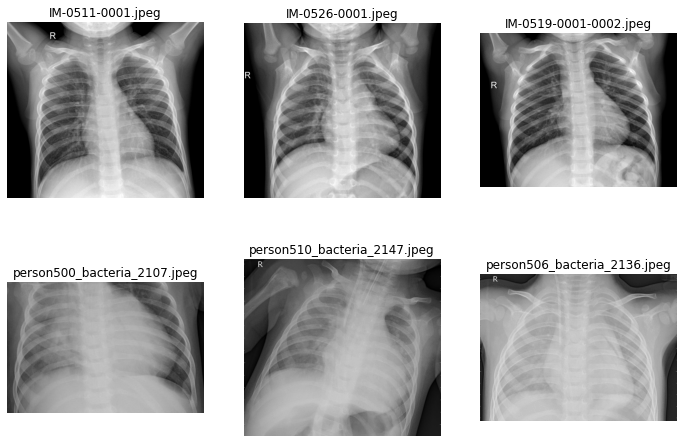

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define our example directories and files
base_dir = '/content/drive/My Drive/chest_xray1'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join( base_dir, 'test')


train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')
validation_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')
test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

train_normal_fnames = os.listdir(train_normal_dir)
train_pneumonia_fnames = os.listdir(train_pneumonia_dir)

# Show some examples
plt.figure(figsize=(12,8))
for n in range(3):
  plt.subplot(2,3,n+1)
  path = os.path.join(train_normal_dir, train_normal_fnames[n])
  img = plt.imread(path)
  plt.imshow(img, cmap='gray')
  plt.title(train_normal_fnames[n])
  plt.axis('off')
  plt.subplot(2,3,n+4)
  path = os.path.join(train_pneumonia_dir, train_pneumonia_fnames[n])
  img = plt.imread(path)
  plt.imshow(img, cmap='gray')
  plt.title(train_pneumonia_fnames[n])
  plt.axis('off')


Let's use ImageDataGenerator to load images from disk. We also use data augmentation for our training images to help prevent overfitting. This data augmentation technique works directly in memory.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
#train_datagen = ImageDataGenerator(
 # rescale = 1./255.,
 # rotation_range = 10,
  #width_shift_range = 0.2,
  #height_shift_range = 0.2,
 # shear_range = 0,
  #zoom_range = 0.2,
  #horizontal_flip = False)

train_datagen = ImageDataGenerator(
    rescale =1/255,
    shear_range=10,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode = 'nearest',
)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_directory(
  train_dir,
  batch_size = 20,
  class_mode = 'binary',
  target_size = (image_size, image_size))

print(train_generator.class_indices)
classes = np.array(train_generator.classes)
(_ , occurences) = np.unique(classes, return_counts=True)
neg = occurences[0]
pos = occurences[1]
tot = neg + pos
print('Training normal cases: {}'.format(neg))
print('Training pneumonia cases: {}'.format(pos))
print('Training total cases: {}'.format(tot))

validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  batch_size = 20,
  class_mode = 'binary',
  target_size = (image_size, image_size))

Found 5222 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}
Training normal cases: 1347
Training pneumonia cases: 3875
Training total cases: 5222
Found 16 images belonging to 2 classes.


Let's train our model. We deal with our imbalanced dataset by setting different weights for our 2 classes, as suggested in https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights. The model will 'pay more attention' to our negative class, which has fewer examples.

In [8]:
weight_for_0 = tot/neg/2.0 
weight_for_1 = tot/pos/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [9]:
history = model.fit(
  train_generator,
  validation_data = validation_generator,
  steps_per_epoch = len(train_generator),
  validation_steps = len(validation_generator),
  epochs = 20,
  class_weight = class_weight,
  verbose = 2)

Epoch 1/20
262/262 - 1456s - loss: 1.7857 - tp: 3374.0000 - fp: 180.0000 - tn: 1167.0000 - fn: 501.0000 - accuracy: 0.8696 - precision: 0.9494 - recall: 0.8707 - auc: 0.8992 - val_loss: 0.1333 - val_tp: 7.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 1.0000 - val_accuracy: 0.9375 - val_precision: 1.0000 - val_recall: 0.8750 - val_auc: 1.0000 - 1456s/epoch - 6s/step
Epoch 2/20
262/262 - 160s - loss: 0.2523 - tp: 3558.0000 - fp: 102.0000 - tn: 1245.0000 - fn: 317.0000 - accuracy: 0.9198 - precision: 0.9721 - recall: 0.9182 - auc: 0.9688 - val_loss: 0.1846 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - 160s/epoch - 612ms/step
Epoch 3/20
262/262 - 159s - loss: 0.1653 - tp: 3643.0000 - fp: 79.0000 - tn: 1268.0000 - fn: 232.0000 - accuracy: 0.9404 - precision: 0.9788 - recall: 0.9401 - auc: 0.9822 - val_loss: 0.1244 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000

Let's plot some training metrics as a function of epochs

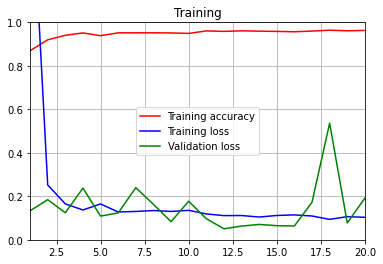

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['recall']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training')
plt.legend(loc=0)
plt.axis([1, len(acc), 0, 1])
plt.grid(True)
plt.figure()
plt.show()

Let's evaluate our model with our test subfolder.

In [12]:
test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator = test_datagen.flow_from_directory(
  test_dir,
  batch_size = 20,
  class_mode = 'binary',
  shuffle = False,
  target_size = (image_size, image_size))

print(test_generator.class_indices)
(_ , occurences) = np.unique(test_generator.classes, return_counts=True)
test_neg = occurences[0]
test_pos = occurences[1]
test_tot = test_neg + test_pos
print('Test normal cases: {}'.format(test_neg))
print('Test pneumonia cases: {}'.format(test_pos))
print('Test total cases: {}'.format(test_tot))

Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}
Test normal cases: 234
Test pneumonia cases: 390
Test total cases: 624


In [13]:
results = model.evaluate(test_generator, steps=len(test_generator))
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)

32/32 [==============================] - 343s 11s/step - loss: 0.2015 - tp: 365.0000 - fp: 20.0000 - tn: 214.0000 - fn: 25.0000 - accuracy: 0.9279 - precision: 0.9481 - recall: 0.9359 - auc: 0.9778
loss :  0.2015354484319687
tp :  365.0
fp :  20.0
tn :  214.0
fn :  25.0
accuracy :  0.9278846383094788
precision :  0.948051929473877
recall :  0.9358974099159241
auc :  0.977832555770874


Let's get predictions of our model on the test images.

In [14]:
predictions = []
labels = []
for i in range(len(test_generator)):
  x, y = next(test_generator)
  predictions.append(model.predict(x))
  labels.append(y)
predictions = np.concatenate(predictions)
labels = np.concatenate(labels)

Let's plot the confusion matrix of the model with a threshold equal to 0.5.

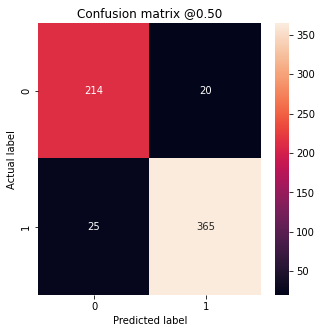

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

plot_cm(labels, predictions)

Let's plot the ROC curve. We find the optimal threshold, which maximizes the Youden's J statistic, as suggested at https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/.

Best Threshold : 0.40


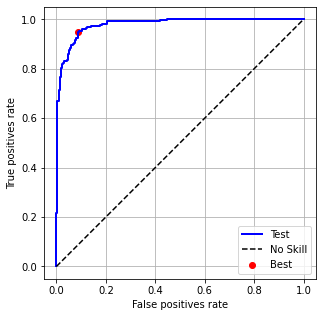

In [16]:
import sklearn.metrics

def plot_roc(name, labels, predictions, **kwargs):
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, predictions)
  plt.figure(figsize=(5,5))
  plt.plot(fpr, tpr, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives rate')
  plt.ylabel('True positives rate')
  plt.grid(True)
  # Youden's J statistic
  J = tpr - fpr
  ix = np.argmax(J)
  best_threshold = thresholds[ix]
  print('Best Threshold : {:.2f}'.format(best_threshold))
  plt.plot([0,1], [0,1], linestyle='--', color='k', label='No Skill')
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='r', label='Best')
  ax = plt.gca()
  ax.set_aspect('equal')
  return best_threshold

best_threshold = plot_roc(
  "Test",
  labels,
  predictions,
  color='b')
plt.legend(loc='lower right')

Let's plot the confusion matrix at optimal threshold.

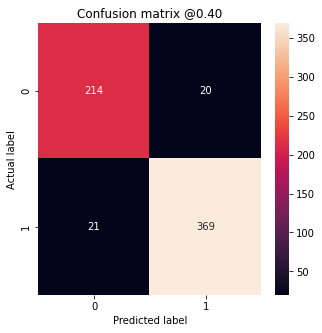

In [17]:
plot_cm(labels, predictions, p=best_threshold)

Let's check the results.

In [18]:
NEW_METRICS = [
  TruePositives(name='tp', thresholds = best_threshold),
  FalsePositives(name='fp', thresholds = best_threshold),
  TrueNegatives(name='tn', thresholds = best_threshold),
  FalseNegatives(name='fn', thresholds = best_threshold),
  BinaryAccuracy(name='accuracy', threshold = best_threshold),
  Precision(name='precision', thresholds = best_threshold),
  Recall(name='recall', thresholds = best_threshold),
  AUC(name='auc')
]
for m in NEW_METRICS:
  m.update_state(labels, predictions) 
  print (m.name, ': ', m.result().numpy())

tp :  369.0
fp :  20.0
tn :  214.0
fn :  21.0
accuracy :  0.9342949
precision :  0.9485861
recall :  0.9461538
auc :  0.97783256


Let's check the results without generators.

In [19]:
import numpy as np
from keras.preprocessing import image

test_normal_fnames = os.listdir(test_normal_dir)
test_pneumonia_fnames = os.listdir(test_pneumonia_dir)

true_negatives = 0
false_positives = 0
for fn in test_normal_fnames:
  path = os.path.join(test_normal_dir, fn)
  img = image.load_img(path, target_size=(image_size, image_size))
  x = image.img_to_array(img)
  x /= 255.0
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  out = model.predict(images)
  if out <= best_threshold:
    true_negatives += 1
  else:
    false_positives += 1

true_positives = 0
false_negatives = 0
for fn in test_pneumonia_fnames:
  path = os.path.join(test_pneumonia_dir, fn)
  img = image.load_img(path, target_size=(image_size, image_size))
  x = image.img_to_array(img)
  x /= 255.0
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  out = model.predict(images)
  if out <= best_threshold:
    false_negatives += 1
  else:
    true_positives += 1

print('Best threshold: ', best_threshold)
print('True negatives: ', true_negatives)
print('False positives: ', false_positives)
print('False negatives: ', false_negatives)
print('True positives: ', true_positives)

Best threshold:  0.39751893
True negatives:  214
False positives:  20
False negatives:  21
True positives:  369
